In [4]:
library(dplyr)
library(ggplot2)
library(zeallot)
library(tidyr)
library(reshape2)
library(cowplot)

In [5]:
analysis <- function(X, Y, display_plot=TRUE){
    spearman <- cor(X, Y, use="pairwise.complete.obs", method="spearman")
    pearson <- cor(X, Y, use="pairwise.complete.obs", method="pearson")
    print(c("Pearson", pearson))
    print(c("Spearman", spearman))
    if (display_plot) {
        ggplot() + geom_point(aes(x=X, y=Y))
    }
}

regression <- function(X, Y, display_plot=TRUE){
    r <- cor(X, Y, use="pairwise.complete.obs")
    Sx <- sd(X)
    Sy <- sd(Y)
    a <- r * Sy / Sx
    b <- mean(Y) - a * mean(X)

    if(display_plot){
        xs <- seq(min(X), max(X), 0.01)
        plt <- ggplot() +
            geom_point(aes(x=X, y=Y), alpha=0.5) +
            geom_line(aes(x = xs, y = a * xs + b), linewidth=1, col="red")
        show(plt)
    }

    return(c(a, b))
}

In [6]:
data <- read.csv("data/data.csv")
data2000 <- data %>% filter(year == 2000)
data2005 <- data %>% filter(year == 2005)
data2010 <- data %>% filter(year == 2010)
data2014 <- data %>% filter(year == 2014)
data2015 <- data %>% filter(year == 2015)
poland <- data %>% filter(country == "Poland")

# Schooling

In [74]:
data_filtered <- data2015 %>% filter(!is.na(schooling) & !is.na(life_expectancy))
X <- data_filtered$schooling
Y <- data_filtered$life_expectancy

[1] "Pearson"           "0.818159436788872"
[1] "Spearman"          "0.844347924774132"


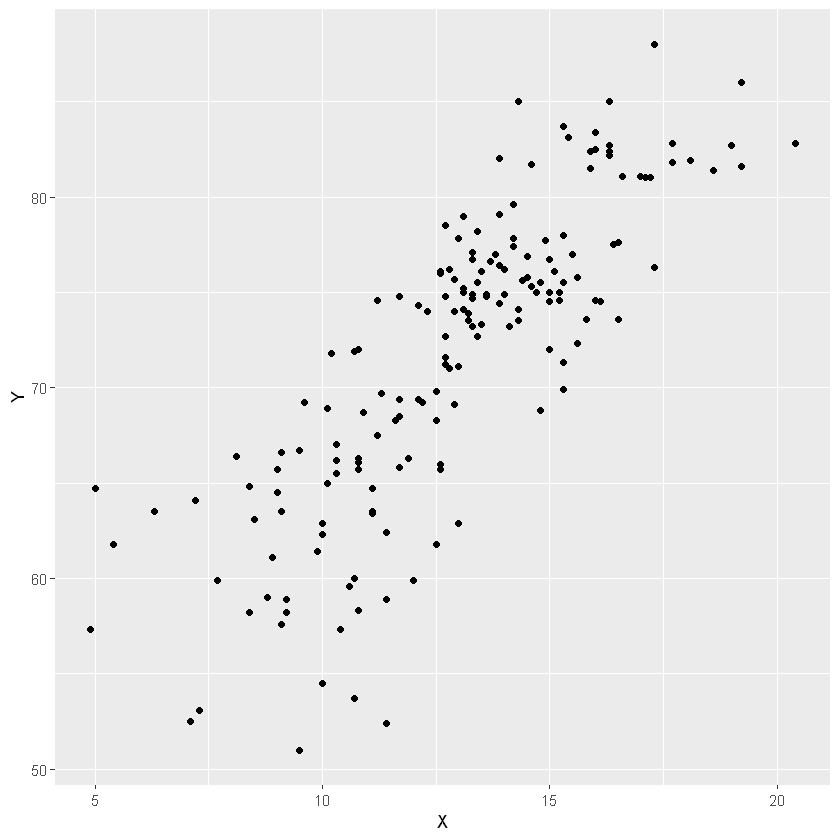

In [75]:
analysis(X, Y)

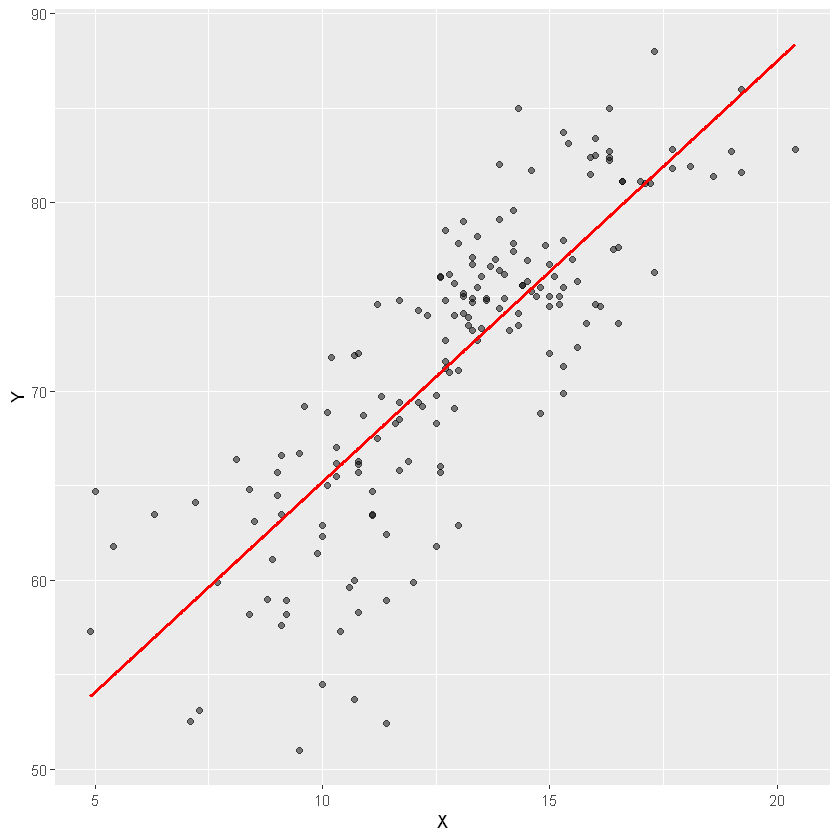

In [76]:
c(a, b) %<-% regression(X, Y)

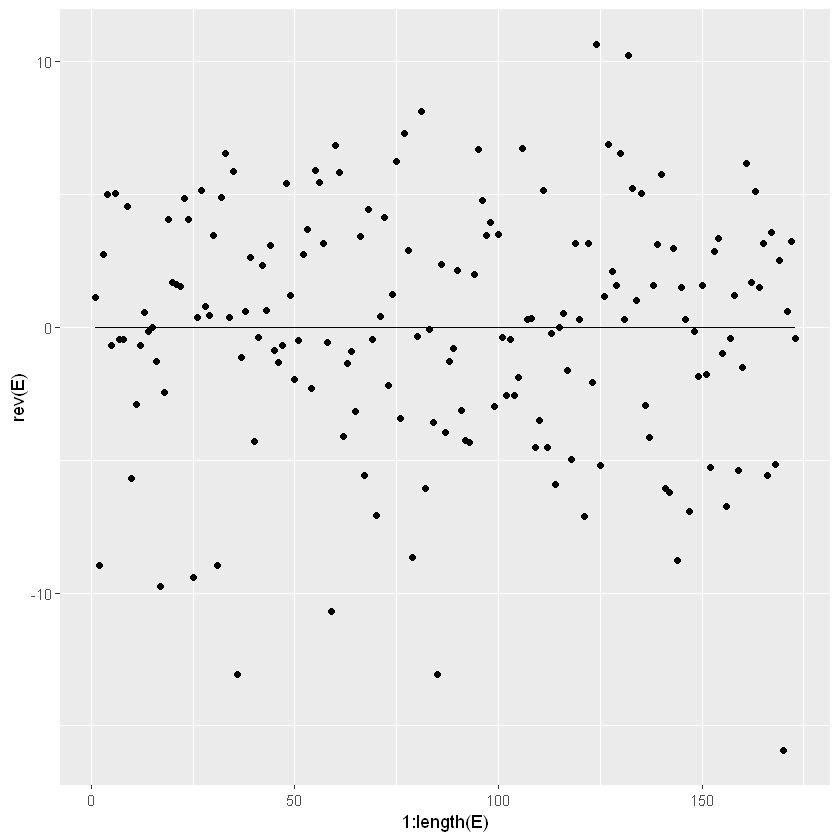

In [78]:
E <- Y - a*X - b
ggplot() + geom_point(aes(1:length(E), rev(E))) + geom_line(aes(1:length(E), 0))

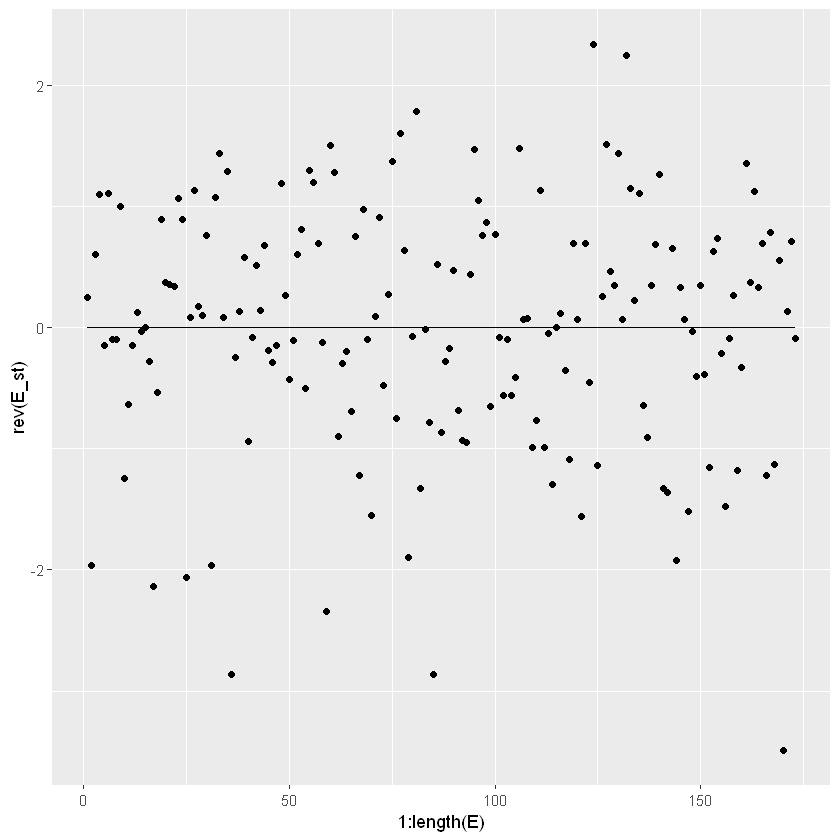

In [80]:
E_st <- E / sd(E)
ggplot() + geom_point(aes(1:length(E), rev(E_st))) + geom_line(aes(1:length(E), 0))

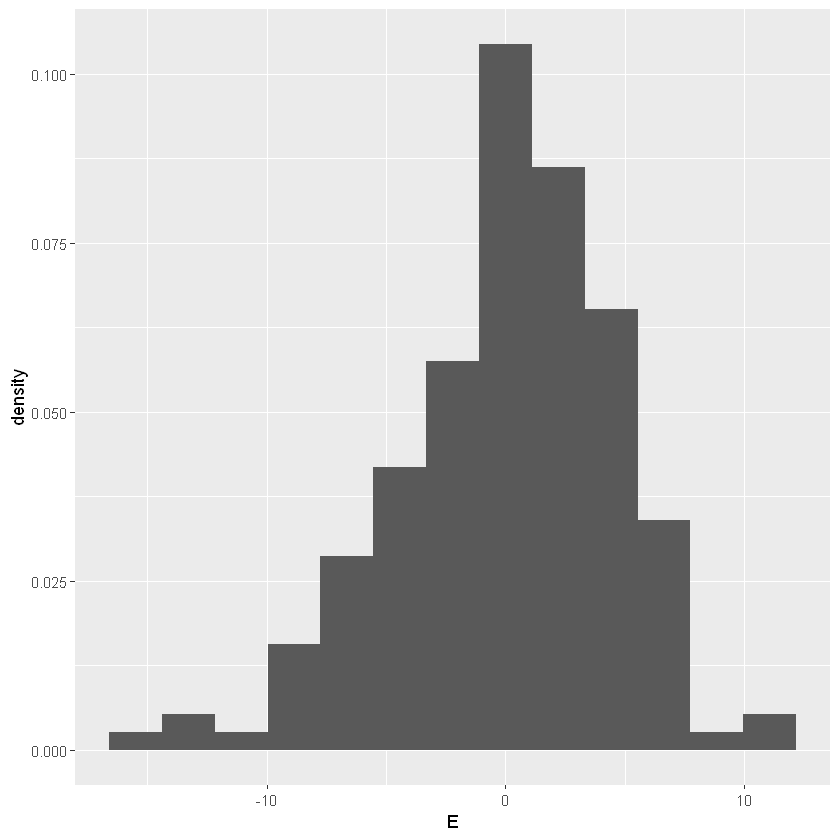

In [59]:
ggplot() + geom_histogram(aes(x=E, y=..density..), bins=13)

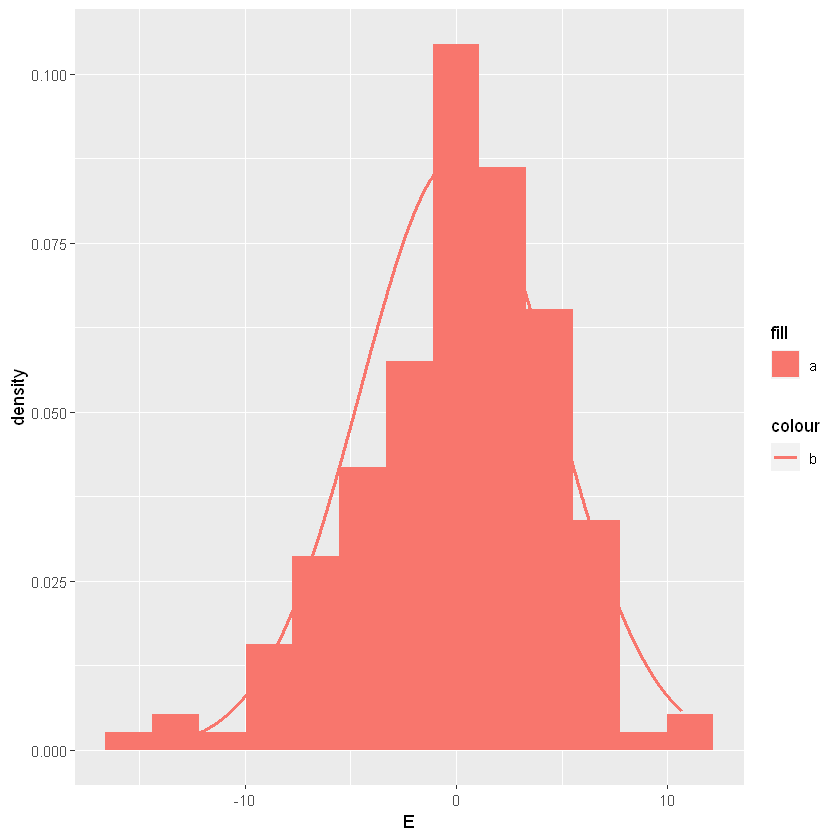

In [65]:
xs <- seq(min(E), max(E), 0.01)
ggplot() + geom_histogram(aes(x=E, y=..density.., fill='a'), bins=13) + geom_line(aes(xs, dnorm(xs, 0, sd(E)), col='b'), linewidth=1)# + scale_color_manual()

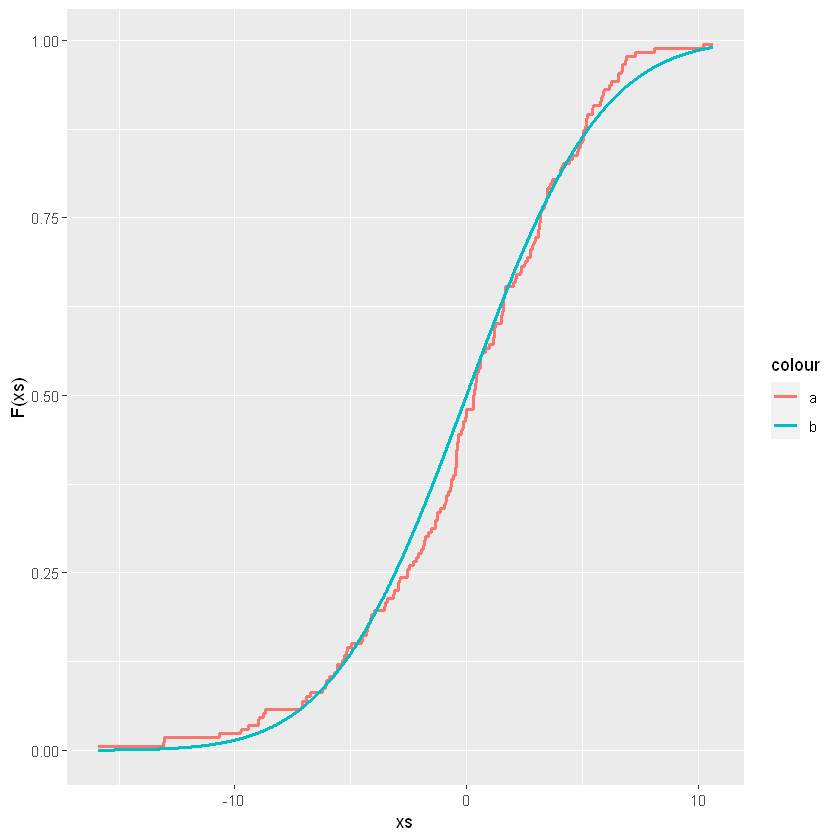

In [58]:
F <- ecdf(E)
xs <- seq(min(E), max(E), 0.01)
ggplot() + geom_line(aes(x=xs, y=F(xs), col='a'), linewidth=1) + geom_line(aes(x=xs, y=pnorm(xs, 0, sd(E)), col='b'), linewidth=1)# + scale_color_manual()

In [22]:
ks.test(E, 'pnorm', 0, sd(E))

Warning message in ks.test.default(E, "pnorm", 0, sd(E)):
"wartości powtórzone nie powinny być obecne w teście Kolmogorowa-Smirnowa"



	Asymptotic one-sample Kolmogorov-Smirnov test

data:  E
D = 0.077247, p-value = 0.2532
alternative hypothesis: two-sided


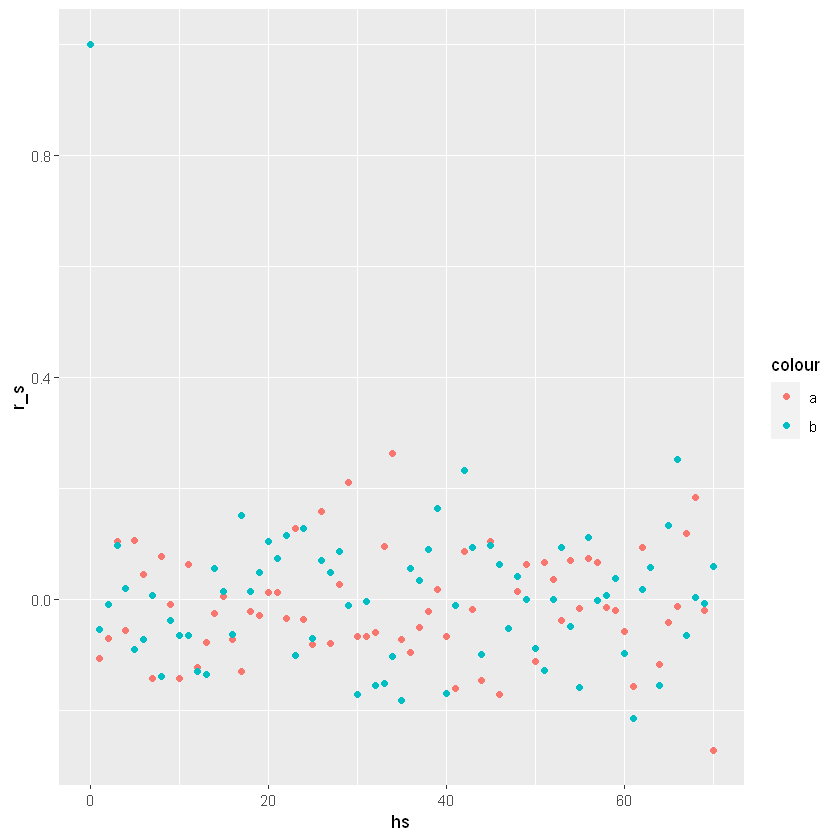

In [68]:
n <- length(E)
hs <- 0:70
Xt <- rnorm(n, 0, sd(E))

g_ <- function(X, h) {
    return ( mean( (X[(1+h):n] - mean(X)) * (X[1:(n-h)] - mean(X)) ) )
}

g_s <- c()
g_s2 <- c()
for (h in hs) {
    g_s <- append(g_s, g_(E, h))
    g_s2 <- append(g_s2, g_(Xt, h))
}

r_s = g_s / g_(E, 0)
r_s2 = g_s2 / g_(Xt, 0)

ggplot() + geom_point(aes(hs, r_s, col='a')) + geom_point(aes(hs, r_s2, col='b'))

# GDP

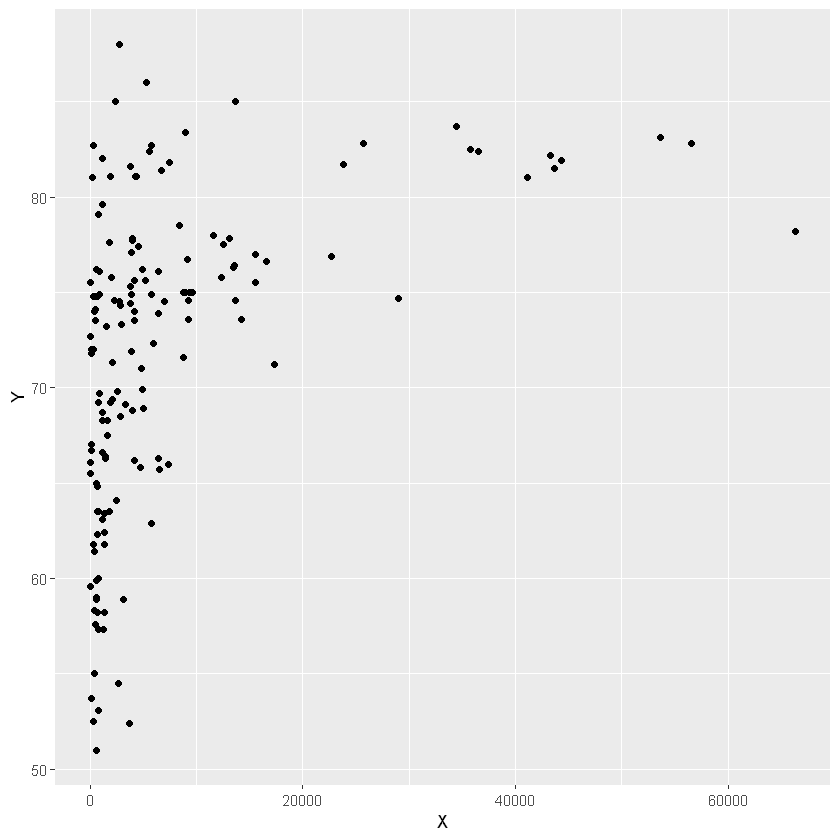

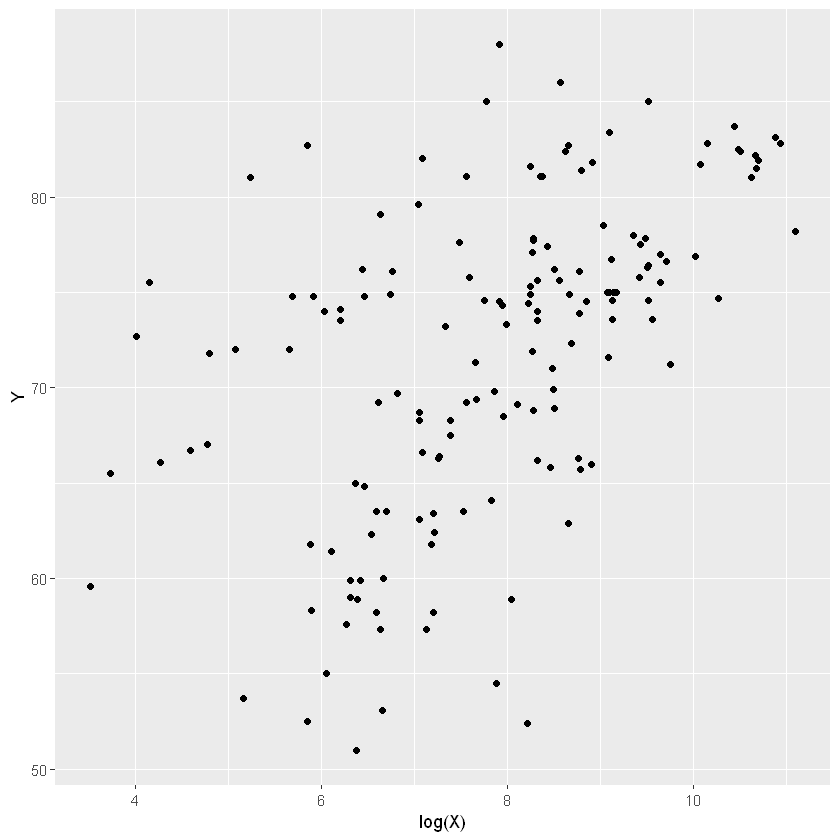

In [6]:
data_filtered <- data2015[!is.na(data2015$GDP) & !is.na(data2015$life_expectancy),]
X <- data_filtered$GDP
Y <- data_filtered$life_expectancy

ggplot() + geom_point(aes(X, Y))
ggplot() + geom_point(aes(log(X), Y))

In [7]:
cor(log(X), Y)

[1] 0.5208085

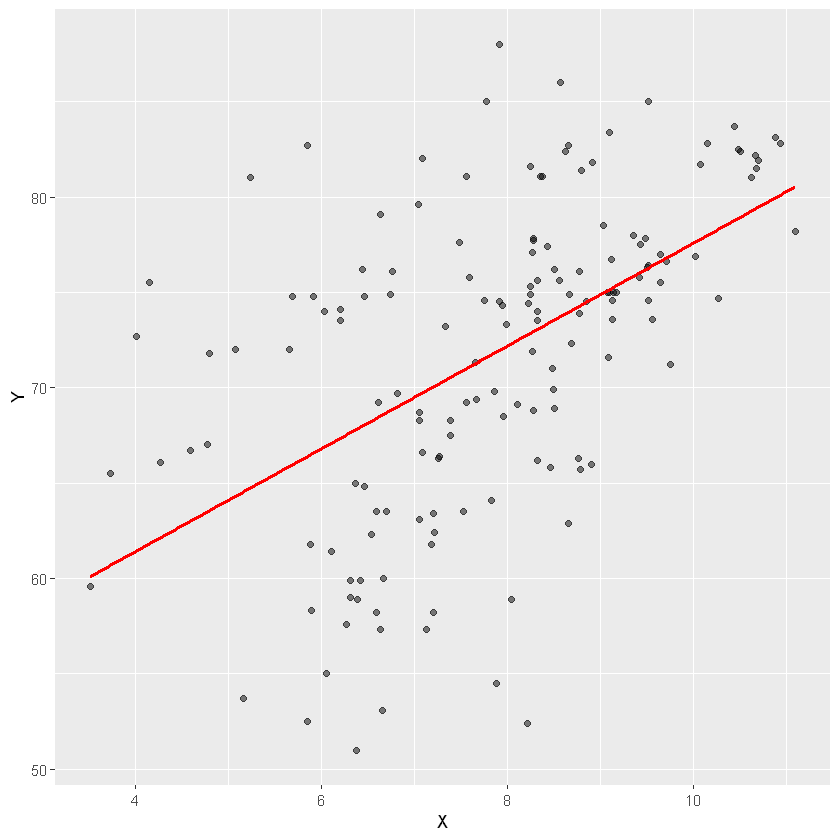

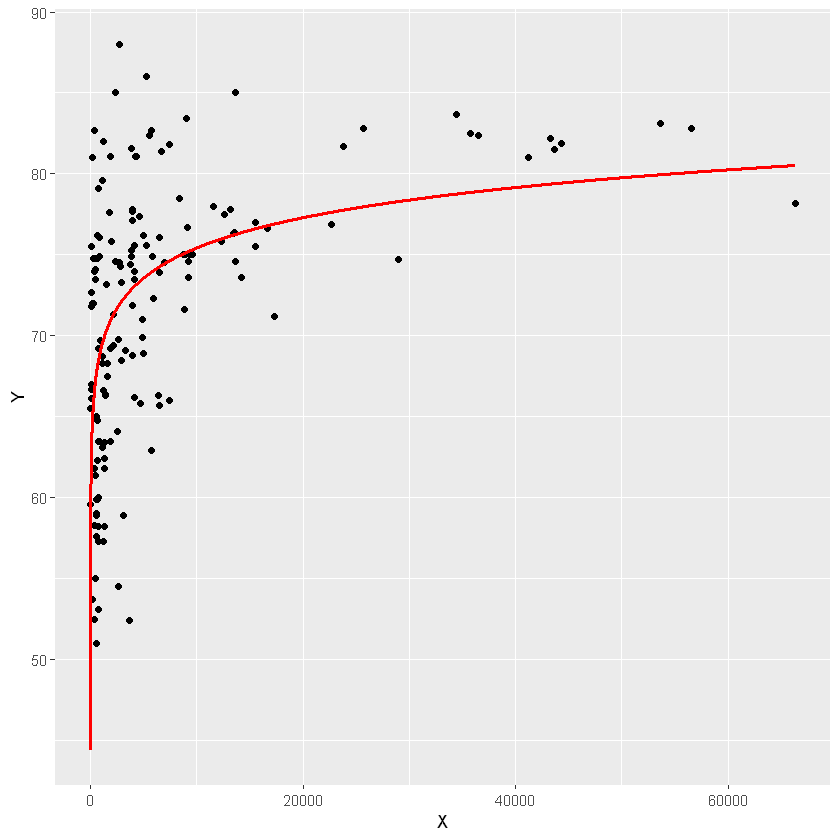

In [9]:
c(a, b) %<-% regression(log(X), Y)
xs <- seq(0.1, max(X), 10)
ggplot() + geom_point(aes(X, Y)) + geom_line(aes(xs, a*log(xs) + b), col='red', linewidth=1)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


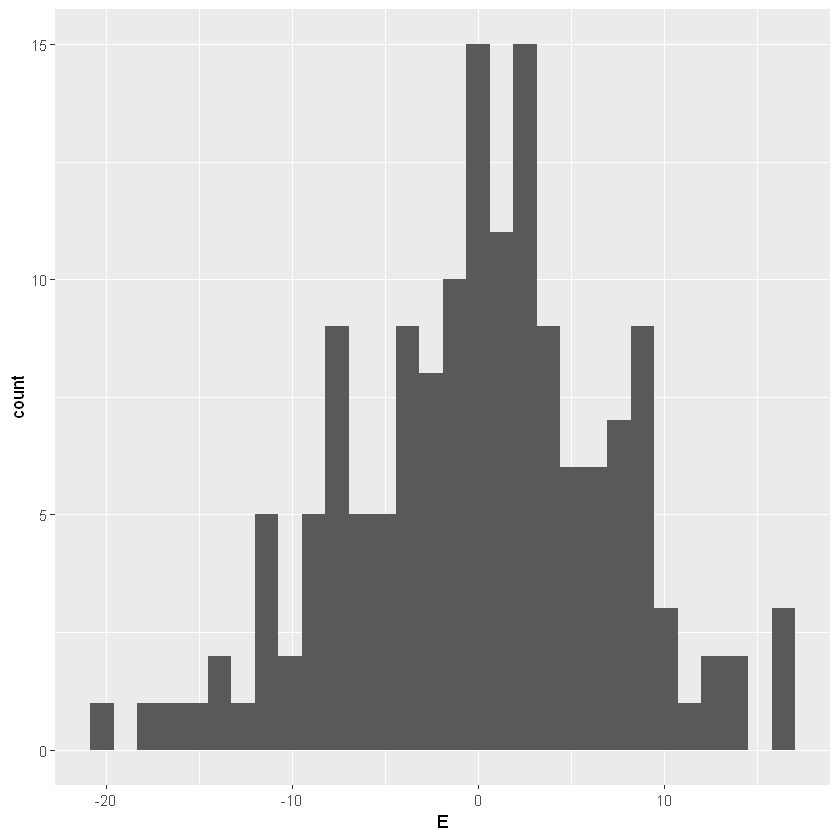

In [12]:
E <- Y - a*log(X) - b
ggplot() + geom_histogram(aes(E))

In [46]:
ks.test(E, 'pnorm', 0, sd(E))


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  E
D = 0.045116, p-value = 0.9126
alternative hypothesis: two-sided


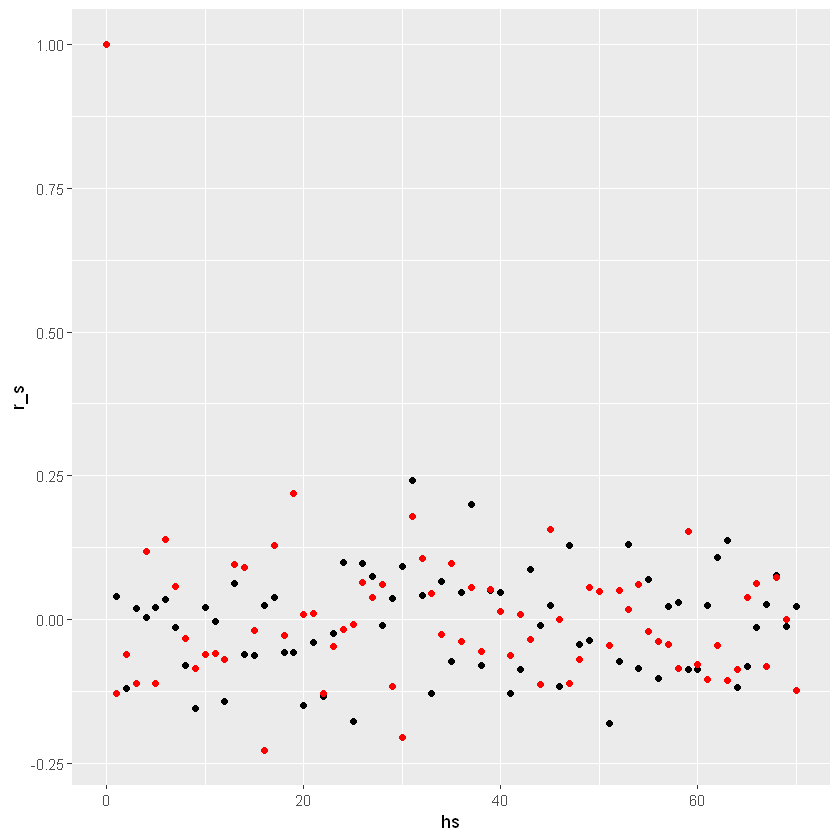

In [82]:
n <- length(E)
hs <- 0:70
Xt <- rnorm(n, 0, sd(E))

g_ <- function(X, h) {
    return ( mean( (X[(1+h):n] - mean(X)) * (X[1:(n-h)] - mean(X)) ) )
}

g_s <- c()
g_s2 <- c()
for (h in hs) {
    g_s <- append(g_s, g_(E, h))
    g_s2 <- append(g_s2, g_(Xt, h))
}

r_s = g_s / g_(E, 0)
r_s2 = g_s2 / g_(Xt, 0)

ggplot() + geom_point(aes(hs, r_s)) + geom_point(aes(hs, r_s2), col='red')